In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import time, datetime
import scipy
import lightgbm as lgb

#띄어쓰기
from pycrfsuite_spacing import TemplateGenerator
from pycrfsuite_spacing import CharacterFeatureTransformer
from pycrfsuite_spacing import PyCRFSuiteSpacing
from soyspacing.countbase import CountSpace

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산
from scipy.sparse import hstack

# 데이터 체크

In [97]:
train = pd.read_csv("C:/cook/dacon/train.csv")
test = pd.read_csv("C:/cook/dacon/public_test.csv")

In [3]:
train.columns

Index(['id', 'year_month', 'text', 'smishing'], dtype='object')

In [4]:
test.columns

Index(['id', 'year_month', 'text'], dtype='object')

In [5]:
train.index

RangeIndex(start=0, stop=295945, step=1)

In [6]:
test.index

RangeIndex(start=0, stop=1626, step=1)

In [7]:
train.head()

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0


In [8]:
test.head()

,id,year_month,text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...


# 분석 시작

In [98]:
print(train['year_month'].min(), train['year_month'].max(),"\n\n",test['year_month'].min(), test['year_month'].max())

NameError: name 'test' is not defined

(array([299.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 332.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 459.,   0.,   0.,   0.,   0.,   0.,
          0., 536.]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
        1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
        2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ]),
 <a list of 24 Patch objects>)

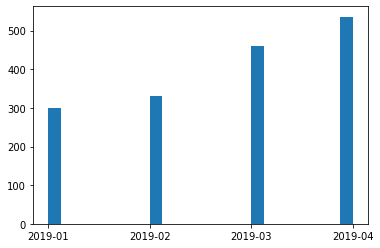

In [99]:
plt.hist(train['year_month'], bins=24)

(array([299., 332., 459., 536.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

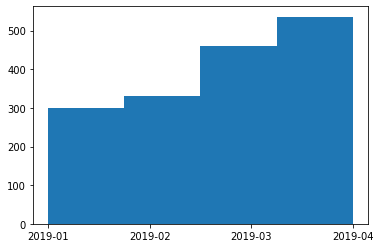

In [11]:
plt.hist(test['year_month'],bins=4)

In [100]:
date = []
p = re.compile('2017-')
q = re.compile('2018-')
for i in train['year_month']:
    if p.match(i):
        date.append(int(i.replace("2017-", "")))
    elif q.match(i):
        date.append(int(i.replace("2018-", "")) + 12)
    else:
        date.append(int(i.replace("2019-", "")) + 24)

In [101]:
season = list(range(0,len(date)))
for i in range(0,len(date)):
    season[i] = math.ceil(date[i] / 3)
train["season"] = season

In [102]:
date = []
p = re.compile('2017-')
q = re.compile('2018-')
for i in test['year_month']:
    if p.match(i):
        date.append(int(i.replace("2017-", "")))
    elif q.match(i):
        date.append(int(i.replace("2018-", "")) + 12)
    else:
        date.append(int(i.replace("2019-", "")) + 24)

NameError: name 'test' is not defined

In [103]:
season = list(range(0,len(date)))
for i in range(0,len(date)):
    season[i] = math.ceil(date[i] / 3)
test["season"] = season

NameError: name 'test' is not defined

In [16]:
print(train.head(),
      test.head(),
      sep = "\n\n")

   id year_month                                               text  smishing  \
0   0    2017-01                           XXX은행성산XXX팀장입니다.행복한주말되세요         0   
1   1    2017-01              오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림         0   
2   2    2017-01  안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...         0   
3   4    2017-01  XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...         0   
4   5    2017-01           1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다         0   

   season  
0       1  
1       1  
2       1  
3       1  
4       1  

       id year_month                                               text  \
0  340000    2019-01  XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...   
1  340001    2019-01   긴급 안내  XXX은행 가락동 지점  - 헬리오XXX 기본XXX    대출이자를 ...   
2  340002    2019-01  XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...   
3  340003    2019-01  XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...   
4  340004    2019-01  XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다.

# 계절 9값 확인 -- 단순 예측(12월 값 *3)
len(train[idx][train['season']==9]), 1150


len(train[idy][train['season']==9])) 4131

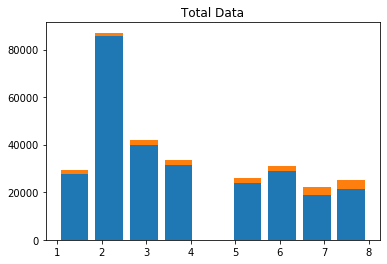

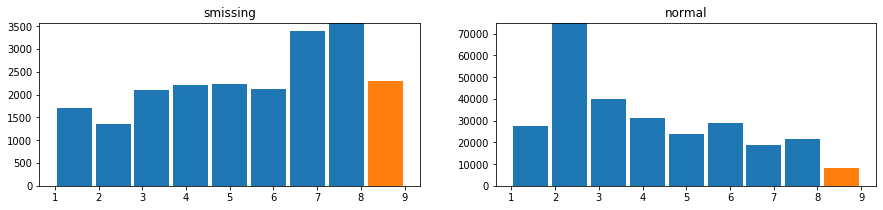

In [17]:
idy = train['smishing'] == 0
idx = train['smishing'] == 1
pred = [9 for i in range(2300)]
pred_ns = [9 for i in range(8262)]


plt.hist((train[idy]['season'],train[idx]['season']), stacked = True, bins = 9, rwidth= 0.8)
plt.title("Total Data")
plt.show()


plt.figure(figsize=(15,3))
plt.subplot(121)
plt.title("smissing")
plt.hist((train[idx]['season'],pred),  stacked = True, bins = 9, rwidth= 0.9)
plt.subplot(122)
plt.title("normal")
plt.hist((train[idy]['season'],pred_ns), stacked = True, bins = 9, rwidth= 0.9)
plt.ylim(0,75000)
plt.show()

# 텍스트 데이터 분석

idx = 스미싱 문자
idy = 정상 문자

In [18]:
train[idx]["text"].head()

9     (광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...
23    (광고)XXX추가 XXX품   특판 안내문XXX 지점에서 취급하고 있는 여신 XXX...
31    (광고)XXX신용관리 XXX 알고 싶다나의 신용과 재무상태는 직접 관리해야지 누군가...
40    (광고)안녕하세요수신을 희망하지 않으실 경우에는 거부 라는 답장을 주시면 KISA ...
50    (광고)한국citi bank 나의 대출한도와 금리는? 대출때문에 고민하고 있다거나 ...
Name: text, dtype: object

In [19]:
train[idy]["text"].head()

0                             XXX은행성산XXX팀장입니다.행복한주말되세요
1                오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림
2    안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...
3    XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...
4             1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다
Name: text, dtype: object

head를 보면 정상 문자의 경우, 단순고객접촉을 의도로 발송하는 경우가 보임.
그러나, 스미싱의 경우 이익을 목적으로 하지 않는 문자는 발송하지 않음.
따라서, Document의 주제를 분석하여 비이익접촉을 걸러내는 방법 활용

In [20]:
def find_smi_word(target):
    for t in target:
        sms_head = []
        sms_heady = []
        sms_tx = []
        sms_ty = []
        p = re.compile(t)
        for i in train[idx]['text']:
            if p.findall(i):
                sms_head.append(1)
                sms_tx.append(i)
        for i in train[idy]['text']:
            if p.findall(i):
                sms_heady.append(1)
                sms_ty.append(i)
        print(sum(sms_head), sum(sms_heady))
        
def del_smi_word(target):
    global clean_doc
    clean_doc = train
    for t in target:
        smishing_index =[]
        p = re.compile(t)
        for i in train[idx].values:
            if p.findall(i[2]):
                smishing_index.append(i[0])
        clean_doc = clean_doc[~clean_doc["id"].isin(smishing_index)]

In [21]:
target = ['ID\s*:', '답장', 'KISA', '톡\s*상담']
find_smi_word(target)

3726 1
8169 4
844 0
788 0


데이터에 "ID:" 라는 텍스트가 있으면 모두 스미싱
 -- 카카오톡 플러스친구(공식계정)가 아닌 친구(비공식계정) 등록을 유도하여 속이는 방법으로 추정

# 텍스트 길이 분석

In [104]:
length_x = [] # 스미싱 문자
length_y = [] # 정상 문자

for i in train['text']:
    length_x.append(len(i))    
for i in train[idy]['text']:
    length_y.append(len(i))

{'whiskers': [<matplotlib.lines.Line2D at 0x2592da07e48>,
 'caps': [<matplotlib.lines.Line2D at 0x2592da07e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x2592d9a6848>],
 'medians': [<matplotlib.lines.Line2D at 0x2592da139c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2592da13fc8>],
 'means': []}

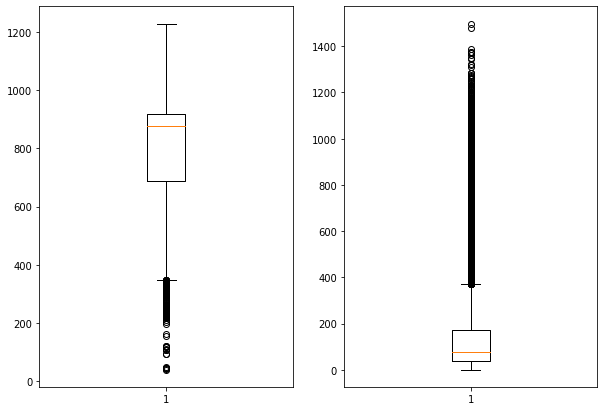

In [23]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.boxplot(length_x)
plt.subplot(122)
plt.boxplot(length_y)

In [105]:
length_x = pd.DataFrame(length_x)
length_y = pd.DataFrame(length_y)
length_x.describe()

,0
count,1626.000000
mean,320.535670
std,251.631687
min,4.000000
25%,130.250000
50%,230.500000
75%,443.750000
max,1155.000000


In [25]:
length_y.describe()

,0
count,277242.000000
mean,133.742395
std,149.335550
min,1.000000
25%,39.000000
50%,75.000000
75%,172.000000
max,1498.000000


길이가 300 ~ 350(whisker 교차지점, 스미싱 whisker 시작부분), 900 ~ 950(스미싱 중앙값 부근)에서 기울기가 급격히 변함

In [26]:
short_len = []
for j in range(50,1201,50):
    short = []
    for i in train.values:   
        if len(i[2]) < j:
            short.append(i)
    short = pd.DataFrame(short)
    short_len.append([j,len(short[short[3] == 1])])
short_len = pd.DataFrame(short_len)
short_len.sum()

0     15000
1    158174
dtype: int64

In [106]:
length_text= []
for i in train.values:
    length_text.append([i[0],len(i[2])])
length_text = pd.DataFrame(length_text)

In [107]:
length_text.rename(columns={0:"id", 1:"length_text"}, inplace =True)
length_text

,id,length_text
0,340000,500
1,340001,618
2,340002,129
3,340003,90
4,340004,282
...,...,...
1621,341621,293
1622,341622,86
1623,341623,88
1624,341624,685


In [108]:
train = pd.merge(train, length_text, how = 'inner')
train

,id,year_month,text,season,length_text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...,9,500
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...,9,618
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...,9,129
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...,9,90
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...,9,282
...,...,...,...,...,...
1621,341621,2019-04,(광고)XXX 고객님안녕하십니까!!고객님의 소중한 업무처리를 도와드린 kb창원중앙동...,10,293
1622,341622,2019-04,고객님 항상 저희 지점을 거래해 주셔서 감사합니다 본점 서비스 설문 전화 받으시면...,10,86
1623,341623,2019-04,XXX 고객님 저희 XXX은행 XXX지점을 이용해주셔서 감사드립니다 이번주도 더 ...,10,88
1624,341624,2019-04,(광고)알림 신청하면 매일 현금 100만원! XXX부동산 리브온지금 XXX부동산 리...,10,685


In [30]:
train[train["smishing"]==1]

,id,year_month,text,smishing,season,length_text
9,10,2017-01,(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...,1,1,917
23,26,2017-01,(광고)XXX추가 XXX품 특판 안내문XXX 지점에서 취급하고 있는 여신 XXX...,1,1,399
31,36,2017-01,(광고)XXX신용관리 XXX 알고 싶다나의 신용과 재무상태는 직접 관리해야지 누군가...,1,1,941
40,45,2017-01,(광고)안녕하세요수신을 희망하지 않으실 경우에는 거부 라는 답장을 주시면 KISA ...,1,1,937
50,58,2017-01,(광고)한국citi bank 나의 대출한도와 금리는? 대출때문에 고민하고 있다거나 ...,1,1,905
...,...,...,...,...,...,...
295927,336357,2018-12,(광고)XXX금전을 요구하는건 사기입니다. 유의하세요!1.부득이하게 높은 이자를 내...,1,8,911
295932,336362,2018-12,(광고)XXX금전을 요구하는건 사기입니다. 유의하세요!1.부득이하게 높은 이자를 내...,1,8,1034
295934,336366,2018-12,(광고)XXX나의 한도금리를 알아보자금전을 요구하는건 사기입니다. 유의하세요!1.부...,1,8,911
295936,336369,2018-12,(광고) XXX항상 (XXX국민)은행을 이용해주셔서 감사합니다. 2018년 12월 ...,1,8,474


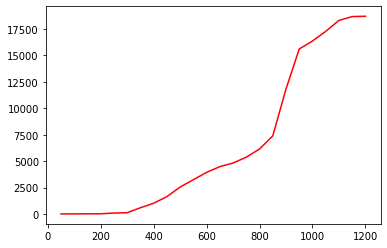

In [31]:
plt.plot(short_len[0], short_len[1], color='r')
# plt.hist(train[idx]['length_text'], bins = 12, cumulative = True, color = 'skyblue')

In [32]:
id_1 = (train['smishing']==1) & (train['season'] == 1)
id_2 = (train['smishing']==1) & (train['season'] == 2)
id_3 = (train['smishing']==1) & (train['season'] == 3)
id_4 = (train['smishing']==1) & (train['season'] == 4)
id_5 = (train['smishing']==1) & (train['season'] == 5)
id_6 = (train['smishing']==1) & (train['season'] == 6)
id_7 = (train['smishing']==1) & (train['season'] == 7)
id_8 = (train['smishing']==1) & (train['season'] == 8)
id_9 = (train['smishing']==1) & (train['season'] == 9)

In [33]:
list_id = [train[id_1]['length_text'],
           train[id_2]['length_text'],
           train[id_3]['length_text'],
           train[id_4]['length_text'],
           train[id_5]['length_text'],
           train[id_6]['length_text'],
           train[id_7]['length_text'],
           train[id_8]['length_text'],
           train[id_9]['length_text']]

([array([  3.,   0.,  19.,  45.,  30.,  65.,  33.,  77., 810., 278., 262.,
          72.]),
  array([   3.,    0.,   90.,   70.,  101.,  111.,  104.,  136., 1400.,
          472.,  438.,  123.]),
  array([   4.,    0.,  137.,  110.,  297.,  191.,  184.,  281., 2352.,
          687.,  738.,  169.]),
  array([6.000e+00, 3.000e+00, 1.920e+02, 1.430e+02, 5.300e+02, 4.210e+02,
         2.620e+02, 3.910e+02, 3.266e+03, 1.022e+03, 9.570e+02, 1.750e+02]),
  array([6.000e+00, 4.000e+00, 2.760e+02, 2.990e+02, 6.960e+02, 4.770e+02,
         2.890e+02, 6.440e+02, 4.271e+03, 1.272e+03, 1.195e+03, 1.790e+02]),
  array([   8.,   15.,  390.,  348.,  889.,  535.,  409.,  907., 5290.,
         1431., 1328.,  182.]),
  array([  12.,   28.,  437.,  716., 1201.,  770.,  626., 1262., 6867.,
         1562., 1463.,  186.]),
  array([  15.,   48.,  468.,  877., 1652., 1316.,  792., 1577., 8359.,
         1791., 1622.,  186.]),
  array([  15.,   48.,  468.,  877., 1652., 1316.,  792., 1577., 8359.,
         179

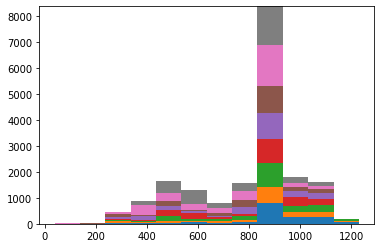

In [34]:
# plt.hist(list_id, stacked=True, bins = 12, cumulative = True)
plt.hist(list_id, stacked=True, bins = 12)

In [35]:
# count = 0
# for i in list_id:
#     count += 1
#     plt.title(count)
#     plt.hist(i, bins=10, density = True)
#     if input() == "":
#         plt.show()

# 띄어쓰기와 형태소 분석

# crf spacing

In [36]:
news_data = pd.read_csv("news_data.csv")

In [ ]:
begin_time = datetime.datetime.now()
to_feature = CharacterFeatureTransformer(
    TemplateGenerator(
        begin=-4,
        end=2,
        min_range_length=3,
        max_range_length=5)
    )

model_path = 'demo_model.crfsuite'
correct = PyCRFSuiteSpacing(to_feature)
correct.train(news_data['text'], model_path)
end_time = datetime.datetime.now()
print(end_time - begin_time)

# soy spacing

In [38]:
begin_time = datetime.datetime.now()
model = CountSpace()
model.load_model('soy_model', json_format=False)
end_time = datetime.datetime.now()
print(end_time - begin_time)

0:00:06.727024


In [39]:
# 특수 문자 제거
train['clean_doc'] = train['text'].str.replace("[^가-힣+]", " ")

In [40]:
train[20:30]

,id,year_month,text,smishing,season,length_text,clean_doc
20,23,2017-01,시장동향(0130 마감 기준)-KOSPI: 2083.59pt(0.81%)126 마감...,0,1,749,시장동향 마감 기준 마감...
21,24,2017-01,연휴 잘 보내셨나요?활기찬 한주 시작하는 즐거운하루되세요XXX드림,0,1,36,연휴 잘 보내셨나요 활기찬 한주 시작하는 즐거운하루되세요 드림
22,25,2017-01,명절선물(과일)발송했습니다약소하지만 성의껏준비했습니다XXX옥동 XXX,0,1,38,명절선물 과일 발송했습니다약소하지만 성의껏준비했습니다 옥동
23,26,2017-01,(광고)XXX추가 XXX품 특판 안내문XXX 지점에서 취급하고 있는 여신 XXX...,1,1,399,광고 추가 품 특판 안내문 지점에서 취급하고 있는 여신 ...
24,27,2017-01,XXX은행XXX지점XXX대리입니다만기관련으로 전XXX드립니다,0,1,33,은행 지점 대리입니다만기관련으로 전 드립니다
25,28,2017-01,새해 복많이 받으시고 축복과 행운이 가득하기를 기원합니다 국XXX XXX 올림,0,1,43,새해 복많이 받으시고 축복과 행운이 가득하기를 기원합니다 국 올림
26,30,2017-01,XXX 고객님안녕하십니까고객님과 첫만남이 바로 엊그제같은데 벌써 아쉬운 인사를 드리...,0,1,355,고객님안녕하십니까고객님과 첫만남이 바로 엊그제같은데 벌써 아쉬운 인사를 드리...
27,32,2017-01,지금이순간가장행복한XXX고객님이셨으면좋겠습니다행복한주말되세요XXX올림,0,1,38,지금이순간가장행복한 고객님이셨으면좋겠습니다행복한주말되세요 올림
28,33,2017-01,XXX 고객님안녕하세요? 다름이 아니라 제가 이번에 XXX센터로 발령받아 이동하게 ...,0,1,160,고객님안녕하세요 다름이 아니라 제가 이번에 센터로 발령받아 이동하게 ...
29,34,2017-01,하루를 지내고 나면 더 즐거운 하루가 오고 좋은 일이 생기면 더 행복한 일을 만들 ...,0,1,89,하루를 지내고 나면 더 즐거운 하루가 오고 좋은 일이 생기면 더 행복한 일을 만들 ...


In [51]:
begin_time = datetime.datetime.now()
clean_doc2 = []
for i in train['clean_doc']:
    clean_doc2.append(correct(i))

end_time = datetime.datetime.now()
print(end_time- begin_time)

KeyboardInterrupt: 

In [ ]:
clean_doc2

In [ ]:
train['clean_doc'] = clean_doc2

# 주제 찾기 시작

In [ ]:
import eunjeon
tagger = eunjeon.Mecab()

In [ ]:
result = []
for i in train['clean_doc']:
    result.append(tagger.nouns(i))

In [ ]:
detokenized_doc = []
for i in range(len(result)):
    t = ' '.join(result[i])
    detokenized_doc.append(t)

detokenized_doc[0]

In [ ]:
train['detoken'] = detokenized_doc

In [20]:
train['clean_doc'] = train['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [25]:
train.isna().sum()

id             0
year_month     0
text           0
smishing       0
season         0
clean_doc      0
anboo          0
myeongjeol     0
sorry          0
callme         0
visit          0
daechool       0
event          0
interest       0
link           0
kakao          0
detoken       42
dtype: int64

In [273]:
# train = pd.read_csv("train_detoken.csv")
# train = train[['id', 'year_month', 'text', 'smishing', 'season', 'length_text', 'clean_doc', 'anboo',
#        'myeongjeol', 'sorry', 'callme', 'visit', 'daechool', 'event',
#        'interest', 'link', 'kakao', 'detoken']]
# train['detoken'].fillna(" ", inplace = True)
# train_set = train.drop(['year_month','text','id', 'clean_doc'], axis=1)


In [274]:
train, valid = train_test_split(train_set, test_size=0.2, random_state = 1)

# 나이브 베이즈

In [275]:
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(train_set['detoken'])
print(X_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
print(X_train_dtm.shape)


(295945, 29218)
(295945, 29218)


In [276]:
smishing = train_set['smishing']
train_set.drop(['detoken','smishing'], axis=1, inplace = True)
scipy.sparse.csr_matrix(train_set.values)
train_set = hstack((train_set, tfidfv))

<295945x12 sparse matrix of type '<class 'numpy.int64'>'
	with 1011985 stored elements in Compressed Sparse Row format>

In [277]:
mod = MultinomialNB()
mod.fit(train_set, smishing)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [73]:
X_test_dtm = dtmvector.transform(valid['detoken']) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(X_test_dtm) #DTM을 TF-IDF 행렬로 변환

smishing_valid = valid['smishing']
valid.drop(['detoken','smishing'], axis=1, inplace = True)
scipy.sparse.csr_matrix(valid.values)
valid = hstack((valid, tfidfv_test))

predicted = mod.predict(valid) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(smishing_valid, predicted)) #예측값과 실제값 비교

NameError: name 'valid' is not defined

In [279]:
test = pd.read_csv("test_detoken.csv")
submission = pd.DataFrame() 
submission['id'] = test['id']

In [280]:
test['detoken'].fillna(" ", inplace = True)

In [281]:
x_test2 = dtmvector.transform(test['detoken'])
tfidf_transformer = TfidfTransformer()
test_set = tfidf_transformer.fit_transform(x_test2)
test_set = test_set.astype("float32")

test.drop(['detoken','id'], axis=1, inplace = True)
scipy.sparse.csr_matrix(test.values)
test_set = hstack((test, test_set))

test_data = lgb.Dataset(test_set)

<1626x12 sparse matrix of type '<class 'numpy.int64'>'
	with 7822 stored elements in Compressed Sparse Row format>

In [282]:
submission['smishing'] = mod.predict(test_set) 
submission.to_csv('submission' + datetime.datetime.now().strftime("%I%M%p") + '.csv', index=False)

In [283]:
submission.mean()

id          340812.500000
smishing    0.132841     
dtype: float64

# Light GBM

In [114]:
train_lda = pd.read_csv("train_lda.csv")
train_lda.fillna(" ", inplace=True)
test = train_lda[-1626:]
train_set = train_lda[:-1626]

In [115]:
train = pd.read_csv("train_detoken.csv")
train_set['smishing'] = train['smishing']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [116]:
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(train_set['detoken'])
print(X_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
print(X_train_dtm.shape)

smishing = train_set['smishing']
train_set.drop(['id','detoken','smishing'], axis=1, inplace = True)
scipy.sparse.csr_matrix(train_set.values)
train_spa = hstack((train_set, tfidfv))

(295945, 29218)
(295945, 29218)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [139]:
x_train, x_val, y_train, y_val= train_test_split(train_spa, smishing, test_size = 0.2)

train_ds = lgb.Dataset(x_train, label = y_train) 
val_ds = lgb.Dataset(x_val, label = y_val) 
params = {'learning_rate': 0.01, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'binary',
          'metric': 'auc',
          'is_training_metric': True,
          'num_leaves': 255, 
          'feature_fraction': 1,
          'bagging_fraction': 0.9, 
          'bagging_freq': 10, 
          'seed':2018} 

model = lgb.train(params, train_ds, 1000, val_ds, verbose_eval=10, early_stopping_rounds=100) 

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.999904
[20]	valid_0's auc: 0.999978
[30]	valid_0's auc: 0.999996
[40]	valid_0's auc: 0.999997
[50]	valid_0's auc: 0.999998
[60]	valid_0's auc: 0.999998
[70]	valid_0's auc: 0.999998
[80]	valid_0's auc: 0.999998
[90]	valid_0's auc: 0.999998
[100]	valid_0's auc: 0.999998
[110]	valid_0's auc: 0.999998
[120]	valid_0's auc: 0.999998
[130]	valid_0's auc: 0.999998
[140]	valid_0's auc: 0.999998
[150]	valid_0's auc: 0.999998
[160]	valid_0's auc: 0.999998
[170]	valid_0's auc: 0.999999
[180]	valid_0's auc: 0.999999
[190]	valid_0's auc: 0.999999
[200]	valid_0's auc: 0.999999
[210]	valid_0's auc: 0.999999
[220]	valid_0's auc: 0.999999
[230]	valid_0's auc: 0.999999
[240]	valid_0's auc: 0.999999
[250]	valid_0's auc: 0.999999
[260]	valid_0's auc: 0.999998
[270]	valid_0's auc: 0.999998
[280]	valid_0's auc: 0.999998
[290]	valid_0's auc: 0.999998
[300]	valid_0's auc: 0.999998
[310]	valid_0's auc: 0.999998
[320]	valid_0's a

In [ ]:
# test = pd.read_csv("test_detoken.csv")
submission = pd.DataFrame() 
submission['id'] = test['id']

In [ ]:
# test['detoken'].fillna(" ", inplace = True)

In [ ]:
x_test2 = dtmvector.transform(test['detoken'])
tfidf_transformer = TfidfTransformer()
test_set = tfidf_transformer.fit_transform(x_test2)
test_set = test_set.astype("float32")

test.drop(['detoken','id'], axis=1, inplace = True)
scipy.sparse.csr_matrix(test.values)
test_set = hstack((test, test_set))

test_data = lgb.Dataset(test_set)

In [137]:
submission['smishing'] = model.predict(test_set) 
submission.to_csv('submission' + datetime.datetime.now().strftime("%I%M%p") + '.csv', index=False)

In [138]:
submission.mean()

id          340812.500000
smishing         0.045937
dtype: float64